# Week 5 Problem 3

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select *Kernel*, and restart the kernel and run all cells (*Restart & Run all*).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select *File* → *Save and CheckPoint*)

5. When you are ready to submit your assignment, go to *Dashboard* → *Assignments* and click the *Submit* button. Your work is not submitted until you click *Submit*.

6. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

7. **If your code does not pass the unit tests, it will not pass the autograder.**

# Due Date: 6 PM, February 19, 2018

In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel, RationalQuadratic, Matern
from nose.tools import assert_equal, assert_in, assert_is_not, assert_is_instance
from numpy.testing import assert_array_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal, assert_index_equal

Let us use _sklearn_ to create a classification dataset for this assignment. We will create a dataset of 300 observations, 4 features and 3 class labels. We will then perform a 80/20 train-test split of the dataset.

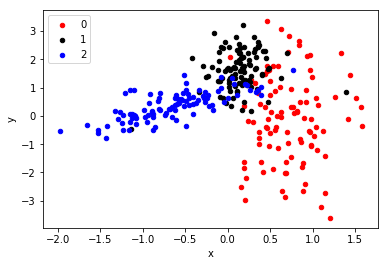

In [2]:
# Generate the dataset
X, y = make_classification(n_samples=300, n_features=4, n_classes=3, n_clusters_per_class=1, random_state=0)

# Perform a 80/20  train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# View the dataset
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0: 'red', 1: 'black', 2: 'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

## Question 1

Create a wrapper function called GP_Classifier that fits a <i>sklearn.gaussian_process.GaussianProcessClassifier</i> model to the training set and makes predictions on the test data. Your function should return the fitted model along with the predictions. We have defined a default kernel for your function.

Note, set the <i>random_state</i> to be 0 for reproducibility.

In [4]:
df.head()

,label,x,y
0,2,-0.674827,0.251702
1,1,0.353322,2.620142
2,0,0.639512,-2.670373
3,1,-0.289100,1.752316
4,0,0.589930,-1.145533


In [5]:
def GP_Classifier(X_train, y_train, X_test, random_state=0):
    '''    
    Parameters
    ----------
    X_train: A numpy.ndarray
    y_train: A numpy.ndarray
    X_test: A numpy.ndarray
    
    Returns
    -------
    model: A sklearn.gaussian_process.GaussianProcessClassifier
    prediction: A numpy.ndarray
    '''
    # YOUR CODE HERE
    # First we construct our Gaussian Process, we only specify the 
    # random_state hyperparameter to ensure reproduceability.
    model = GaussianProcessClassifier(random_state=random_state)

    # Fit estimator to scaled training data
    model = model.fit(X_train, y_train)
    
    prediction = model.predict(X_test)

    return model, prediction

In [6]:
# Test your function
model1, prediction1 = GP_Classifier(X_train, y_train, X_test)

In [7]:
assert_equal(isinstance(model1, GaussianProcessClassifier), True)
assert_equal(isinstance(prediction1, np.ndarray), True)
assert_equal(len(prediction1), 60)


From the notebook, recall that the kernel is the primary hyperparameter for the Gaussian Process Classifier. The accuracy score of the default model is approximately 83.3% using the default radial-basis function kernel (_1.0 * RBF(1.0)_). Can we do better with a different kernel?

In [8]:
# Accuracy score with default RBF kernel
accuracy_score(y_test, prediction1)

0.83333333333333337

## Question 2

 Determine an appropriate kernel which results in an accuracy higher than 83.3% for the Gaussian Process Classifier. The function GP_Classifier_Kernel() should be almost the same as your function in Question 1 except with a defined kernel for your model. Your function should have <i>random_state=0</i> and output the model along with the predictions as before.
 
 __Hint__: 
1. You might want to set `warm_start=True` when defining the GaussianProcessClassifier in order to reduce computation time. 
2. You do not have to define a complicated kernel function. Try the DotProduct, ConstantKernel, RationalQuadratic, or Matern kernel with the default parameters and see what you get.

__Note__: You can achieve 90%+ accuracy but the computation time will take extremely long. Your model does not have to perform that well --- you just need to do better than 83.3% to receive full points. Computational complexity and performance is a common trade-off you will experience in data science.

In [33]:
def GP_Classifier_Kernel(X_train, y_train, X_test, random_state=0):
    '''    
    Parameters
    ----------
    X_train: A numpy.ndarray
    y_train: A numpy.ndarray
    X_test: A numpy.ndarray
    
    Returns
    -------
    model: A sklearn.gaussian_process.GaussianProcessClassifier
    prediction: A numpy.ndarray
    '''
    # YOUR CODE HERE           
    kernels = 1.0 * Matern(length_scale=1.0)
    
    model = GaussianProcessClassifier(kernel=kernels, warm_start=True, random_state=random_state)

    # Fit estimator to scaled training data
    model = model.fit(X_train, y_train)
    
    prediction = model.predict(X_test)

    return model, prediction

In [34]:
# Might take a few minutes to run
model2, prediction2 = GP_Classifier_Kernel(X_train, y_train, X_test)

# Compute accuracy score
accuracy_score(y_test, prediction2)

0.8666666666666667

In [35]:
assert_equal(isinstance(model2, GaussianProcessClassifier), True)
assert_equal(isinstance(prediction2, np.ndarray), True)
assert_equal(model2.kernel is not None, True, msg="Make sure you define a kernel.")
assert_equal(accuracy_score(y_test, prediction2) > .833, True, msg="Your model accuracy needs to be higher than 83.3%.")


Lets take a look at the confusion matrix for the default GPC model and the one with a kernel.

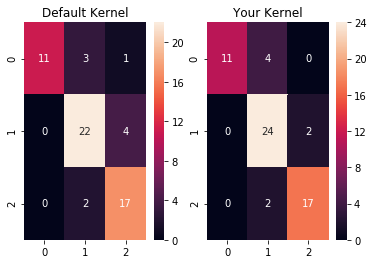

In [36]:
confusion = confusion_matrix(y_test, prediction1)
confusion2 = confusion_matrix(y_test, prediction2)
fig, ax =plt.subplots(1,2)
sns.heatmap(confusion, annot=True, ax=ax[0])
sns.heatmap(confusion2, annot=True, ax=ax[1])
ax[0].set_title('Default Kernel')
ax[1].set_title('Your Kernel')

## Question 3

![prob3_solution](images/prob3_sol.png)

You've already learned that there are other metrics besides accuracy. Create a function plot_confusion() that takes the true label and predicted labels, computes the confusion matrix and plots a heatmap as shown. Note, you do not have to replicate the plot but to pass all of the assertions, you need to do the following:

- Make sure your function returns a _matplotlib.axes.Axes_ object.
- Set a title for the plot.
- Have the class labels on the axes of the plot.

**Hint**: You can use the built-in function from sklearn to compute the confusion matrix. It is also easier to use Seaborn to plot the heatmap than matplotlib (since you can just set _annot=True_ to annotate the heatmap).

In [43]:
def plot_confusion(true_label, prediction):
    '''    
    Parameters
    ----------
    model1: A sklearn.gaussian_process.GaussianProcessClassifier
    model2: A sklearn.gaussian_process.GaussianProcessClassifier
    
    Returns
    -------
    plots: A sklearn.gaussian_process.GaussianProcessClassifier
    '''
    # YOUR CODE HERE
    fig, ax = plt.subplots()
    confusion = confusion_matrix(true_label, prediction)
    sns.heatmap(confusion, annot=True)
    ax.set_title('Confusion Matrix')

    return ax

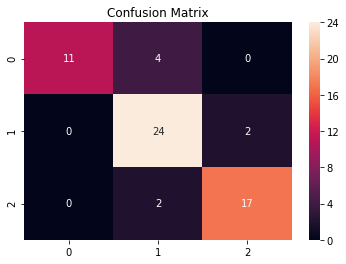

In [44]:
# Plot of the confusion matrix for with your kernel
your_model_cm = plot_confusion(y_test, prediction2)

In [45]:
assert_is_instance(
    your_model_cm, mpl.axes.Axes,
    msg="Your function should return a matplotlib.axes.Axes object."
)
assert_is_not(
    len(your_model_cm.title.get_text()), 0,
    msg="Your plot doesn't have a title."
)
assert_is_not(
    your_model_cm.get_ylim(), (3.0,0),
    msg="Your plot should be 3 by 3."
)
assert_is_not(
    your_model_cm.get_xlim(), (3.0,0),
    msg="Your plot should be 3 by 3."
)
